## Exercise: AFLOW Database + AFLUX

**Aim:** Programmatically expose the same functionality as our web search interface at https://aflow.org/advanced.php

- AFLUX enables search through the query string of the URL ```?<operator>``` by exposing several logical operators.
- Operators can be inter-property and/or intra-property.

### List of logical operators and AFLUX syntax
|Logical operator |      AFLUX syntax          |        Operator             |
| --------------  |:--------------------------:| ---------------------------:|
| ```<block>```   |    ```(``` and ```)```     |  Intra- and inter-property  |
| ```<AND>```     |          ```,```           |  Intra- and inter-property  |
| ```<OR>```      |          ```:```           |  Intra- and inter-property  |
| ```<NOT>```     |          ```!```           |       Intra-property        |
| ```<loose>```   |          ```*```           |       Intra-property        |
| ```<string>```  |          ```'```           |       Inter-property        |
| ```<mute>```    |          ```$```           |       Intra-property        |

- In AFLUX operators are used to create a query. In our terminology a query is comprised of a **matchbook** and **directives**.

    ![](../images/AFLUX_URL.png)

### Matchbook:
- Materials keywords with arguments: ```<server>?species((Na:K),Cl),nspecies(2),Egap(1*,*5),energy_cell```.

### Directives:
- Used for formatting, moving between layers (catalog) and pagination.
- **format** takes args ```"json"``` and ```"html"```.
- **catalog** takes args ```"icsd"```, ```"lib1"```, ```"lib2"```, ...
- **paging** controls page number, number of entries per page, and sorting. By default entries are sorted in ascending order of first materials keyword. Order can be reversed by using a negative page number.


## Python helper function
The following code block enables the quick interaction with AFLUX using python.

In [12]:
import json
from json import JSONDecodeError
from urllib.request import urlopen

SERVER="https://aflow.org"
API="/API/aflux/?"

# Download a AFLUX response and return it as list of dictionaries
def aflux_request(matchbook, paging=1, no_directives=False):
    request_url = SERVER + API + matchbook
    if not no_directives:
        request_url += f",$paging({paging}),format(json)"
    server_response = urlopen(request_url)
    response_content  = server_response.read().decode("utf-8")
    # Basic error handling
    if server_response.getcode() == 200:
        try:
            return json.loads(response_content)
        except JSONDecodeError:
            pass
    print("AFLUX request failed!")
    print(f"  URL: {request_url}")
    print(f"  Response: {response_content}")
    return []

# Print the build in help of AFLUX
def aflux_help(keyword=None):
    if keyword is None:
        # General help (https://aflow.org/API/aflux/?)
        help_data = aflux_request("", no_directives=True)
        print("\n".join(help_data))
    else:
        # Help regarding a specific keyword (https://aflow.org/API/aflux/?help(keyword))
        help_data = aflux_request(f"help({keyword})")
        for key, entry in help_data.items():
            print(key)
            print(f"  description: {entry['description']}")
            print(f"  units: {entry['units']}")
            print(f"  status: {entry['status']}")
            comment = "\n    ".join(entry["__comment__"]).strip()
            if comment:
                print(f"  comment:\n    {comment}")

### 1. Getting help
Print the help for `Egap` and `energy_cell`.

In [13]:
# use the aflux_help function
aflux_help("Egap,energy_cell")

Egap
  description: Returns the electronic band gap.
  units: eV
  status: production
energy_cell
  description: Returns the total ab initio energy per cell.
  units: eV/cell
  status: production


### 2. Collect multiple parameter at once
Collect the values of the band gaps (`Egap`) and the energies per cell (`energy_cell`) for all entries in the _ICSD_ collection. Can you limit the results to entries with a band gap between 0.01 and 10.0?

In [14]:
data_gap = aflux_request("catalog(icsd),Egap(0.01*,*10.0),energy_cell", 0)

It can be helpful to save the data received from AFLUX while testing. A easy way to do so is to save them as `.json` file.

In [15]:
from pathlib import Path
out_path = Path("aflux_save.json")
out_path.write_text(json.dumps(data_gap, indent=4));
# loading the data later:
# data_gap = json.loads(out_path.read_text())

In [16]:
#Content of the saved file
!head -n 20 aflux_save.json

[
    {
        "compound": "Cl4Pd2",
        "auid": "aflow:00ee65a6b4396cc9",
        "aurl": "aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/ORC/Cl2Pd1_ICSD_421215",
        "spacegroup_relax": 58,
        "Pearson_symbol_relax": "oP6",
        "catalog": "ICSD",
        "Egap": 1.6249,
        "energy_cell": -16.3468
    },
    {
        "compound": "Ce1O2",
        "auid": "aflow:004bf05300aebbf8",
        "aurl": "aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/FCC/Ce1O2_ICSD_180955",
        "spacegroup_relax": 225,
        "Pearson_symbol_relax": "cF12",
        "catalog": "ICSD",
        "Egap": 2.4252,
        "energy_cell": -24.0454


To visualize the distribution of band gaps we can use matplotlib

In [17]:
from matplotlib import pyplot as plt

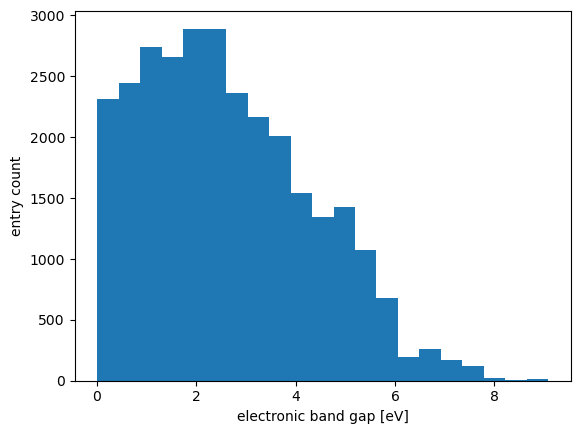

In [18]:
# create a flat array of all Egap data points
egap_collection = [entry["Egap"] for entry in data_gap]
plt.hist(egap_collection, bins=21)
plt.xlabel("electronic band gap [eV]")
plt.ylabel("entry count")
plt.show()

### 3. Visualization
Now visualize the total ab initio energy per cell in the same way.

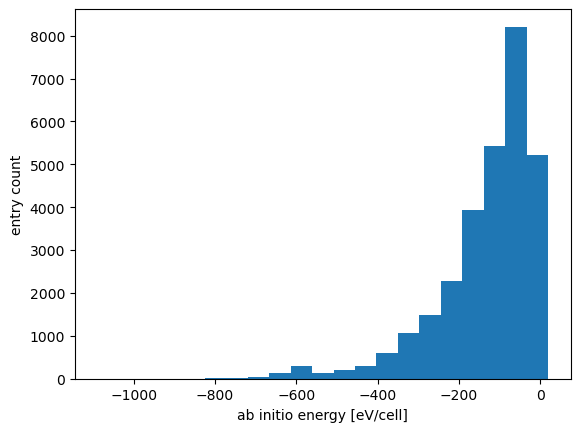

In [19]:
energy_cell_collection = [entry["energy_cell"] for entry in data_gap]
plt.hist(energy_cell_collection, bins=21)
plt.xlabel("ab initio energy [eV/cell]")
plt.ylabel("entry count")
plt.show()

### 4. Data manipulation
Often the data gathered from AFLUX needs to be processed to be useful for a certain task. If we want for example to check if the calculations in the AFLOW database relaxed as expected we can check the maximal stress tensor `stress_tensor` for all entries in the _ICSD_ catalog.

First check the help for `stress_tensor` and then load the data.

In [20]:
aflux_help('stress_tensor')

stress_tensor
  description: Returns the stress tensor for the relaxed structure.
  units: kbar
  status: production


In [21]:
data_stress = aflux_request("stress_tensor,catalog(icsd)",0)

In contrast to before we now need to process the values stored in the entries in a loop. (the maximum stress tensor needs to cover both the positive and negative space)

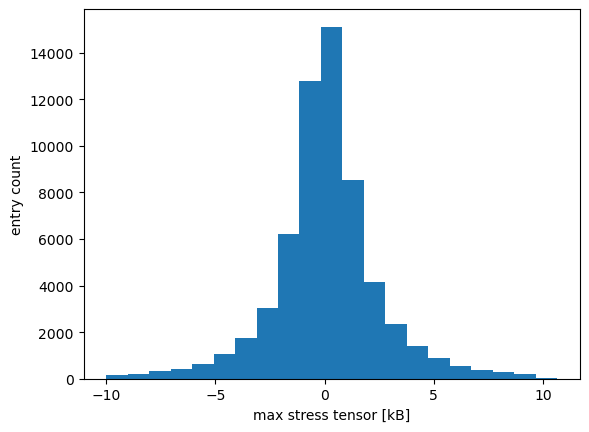

In [22]:
stress_collection = []
for entry in data_stress:
    stress_max = max(entry["stress_tensor"])
    stress_min = min(entry["stress_tensor"])
    if (stress_max>abs(stress_min)):
        stress_collection.append(stress_max)
    else:
        stress_collection.append(stress_min)
plt.hist(stress_collection, bins=21)
plt.xlabel("max stress tensor [kB]")
plt.ylabel("entry count")
plt.show()